<a href="https://colab.research.google.com/github/TienLungSun/PyTorch-deep-learning/blob/main/3.%20Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchsummary import summary
import random
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [2]:
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


# Read excel data file

In [3]:
from google.colab import files
uploaded = files.upload()

Saving 0. Machine learning - Iris data.xlsx to 0. Machine learning - Iris data (1).xlsx


In [4]:
fnameLst = list(uploaded.keys())
fname = fnameLst[0]
print(fname)

0. Machine learning - Iris data.xlsx


In [5]:
import pandas as pd
df=pd.read_excel(fname)

In [6]:
df.head(5)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [7]:
df.tail(5)

,Sepal.Length,Sepal.Width,Petal.Length,Petal.Width,Species
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica
149,5.9,3.0,5.1,1.8,virginica


In [8]:
df.columns

Index(['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width',
       'Species'],
      dtype='object')

In [9]:
dfX = df[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width']]
dfY = df['Species']

In [10]:
#convert dfY from string to integer 0, 1, 2
lstY1 = dfY.values.tolist()
lstY = []
for elt in lstY1:
  if(elt == 'setosa'):
    lstY.append(0)
  elif (elt == 'versicolor'):
    lstY.append(1)
  elif (elt == 'virginica'):
    lstY.append(2)
  else:
    print("Wrong label", elt)

In [11]:
#convert data to numpy array
numpyX = np.array(dfX.values)
numpyY = np.array(lstY)
print(numpyX.shape, numpyY.shape)

(150, 4) (150,)


# Split input data to train and test data

In [12]:
from sklearn.model_selection import train_test_split
trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
print(trainX.shape, testX.shape, trainY.shape, testY.shape)

(120, 4) (30, 4) (120,) (30,)


# Define NN

In [13]:
MyNet = nn.Sequential(
    nn.Linear(4, 56),
    nn.Sigmoid(),
    nn.Linear(56, 56),
    nn.Sigmoid(),
    nn.Linear(56, 3),
)
MyNet.to(device)

Sequential(
  (0): Linear(in_features=4, out_features=56, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=56, out_features=56, bias=True)
  (3): Sigmoid()
  (4): Linear(in_features=56, out_features=3, bias=True)
)

In [15]:
BATCH_SIZE = 20
summary(MyNet, input_size=(BATCH_SIZE, 4))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 20, 56]             280
           Sigmoid-2               [-1, 20, 56]               0
            Linear-3               [-1, 20, 56]           3,192
           Sigmoid-4               [-1, 20, 56]               0
            Linear-5                [-1, 20, 3]             171
Total params: 3,643
Trainable params: 3,643
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.03
Params size (MB): 0.01
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


# Run training-test N times

In [16]:
train_lossLst = []
test_accuracyLst = []
for i in range(1, 6):
  print("\nTrain-test ", i, end= " ")
  trainX, testX, trainY, testY = train_test_split(numpyX, numpyY, test_size=0.20, random_state=0)
  tensorX = torch.FloatTensor(trainX).to(device)
  tensorY = torch.LongTensor(trainY).to(device)
  torch_dataset = Data.TensorDataset(tensorX, tensorY)
  loader = Data.DataLoader(
      dataset=torch_dataset,  
      batch_size=BATCH_SIZE,      
      shuffle=True,       
      num_workers=0,   
  )

  # initialize NN weights
  for name, param in MyNet.named_parameters():
    if(param.requires_grad):
      torch.nn.init.normal_(param, mean=0.0, std=0.02)
  loss_func = torch.nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(MyNet.parameters(), lr=0.0003)

  # train NN 
  print("epoch", end=": ")
  epoch_lossLst=[]
  for epoch in range(1, 1000):
    if(epoch%100 == 0):
      print(epoch, end=",")
    for (batchX, batchY) in loader:
      batchY_hat = MyNet(batchX)
      loss = loss_func(batchY_hat, batchY)
      epoch_lossLst.append(float(loss))
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
  train_lossLst.append(epoch_lossLst) 

  tensorX = torch.FloatTensor(testX).to(device)
  tensorY = torch.LongTensor(testY).to(device)
  tensorY_hat = MyNet(tensorX)

  #calculate accuracy
  correct = OneMissClassifiedAsZero = ZeroMissClassifiedAsOne =0
  tensorY_hat = torch.softmax(tensorY_hat, 1)
  MaxIdxOfEachRow = torch.max(tensorY_hat, 1)[1]
  totalNoTestData = tensorY.shape[0]
  for i in range(totalNoTestData):
    if (int(MaxIdxOfEachRow[i]) == int(tensorY[i])):
      correct += 1
    elif (int(MaxIdxOfEachRow[i]) == 1):
      OneMissClassifiedAsZero +=1
    else:
      ZeroMissClassifiedAsOne +=1
  
  accuracy = correct/totalNoTestData
  error1 = OneMissClassifiedAsZero/totalNoTestData
  error2 = ZeroMissClassifiedAsOne/totalNoTestData
  print("==> %.2f, %.2f, %.2f" % (accuracy,error1,error2))
  test_accuracyLst.append(accuracy)


Train-test  1 epoch: 100,200,300,400,500,600,700,800,900,==> 1.00, 0.00, 0.00

Train-test  2 epoch: 100,200,300,400,500,600,700,800,900,==> 1.00, 0.00, 0.00

Train-test  3 epoch: 100,200,300,400,500,600,700,800,900,==> 1.00, 0.00, 0.00

Train-test  4 epoch: 100,200,300,400,500,600,700,800,900,==> 1.00, 0.00, 0.00

Train-test  5 epoch: 100,200,300,400,500,600,700,800,900,==> 1.00, 0.00, 0.00


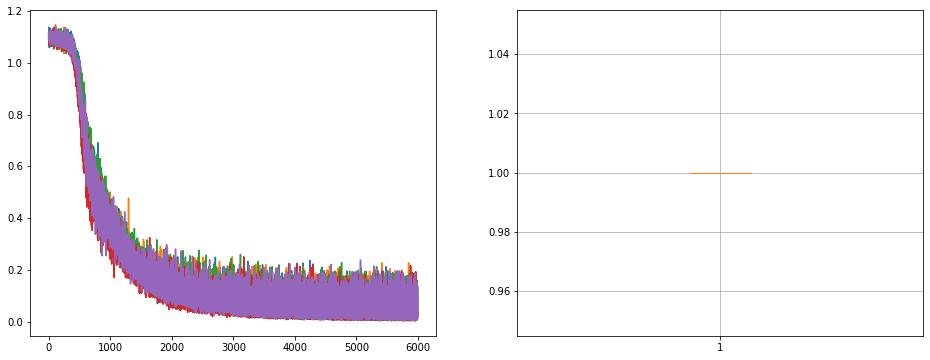

In [17]:
fig=plt.figure(figsize=(16, 6))
fig.add_subplot(1, 2, 1) #1 row, 2 cols
for lst in train_lossLst:
  plt.plot(lst)
fig.add_subplot(1, 2, 2) 
plt.boxplot(test_accuracyLst)
plt.grid()
plt.show()